In [52]:
import pandas as pd
from pandas import Grouper
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import random
from random import sample

import warnings
warnings.filterwarnings("ignore")

In [2]:
#notify me when a long running cell is complete
%load_ext jupyternotify
import time

<IPython.core.display.Javascript object>

In [53]:
content = pd.read_csv('data/movie_titles3.csv', index_col=False, names = ['id', 'year', 'title'])
content.head()

,id,year,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [4]:
content['year'].describe()

count    17763.000000
mean      1990.263694
std         16.507891
min       1896.000000
25%       1985.000000
50%       1997.000000
75%       2002.000000
max       2005.000000
Name: year, dtype: float64

In [5]:
content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      17770 non-null  int64  
 1   year    17763 non-null  float64
 2   title   17770 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 416.6+ KB


# Year Release

There are a few missing years - adding those in.

I'm assuming that people identify heavily with the content that they grew up with or a certain styles of content. For that reason, I'm going to bin films by decade.

However, considering the low outliers anything before 1960 will be binned together. Q1 - 1.5IQR

In [6]:
content[content['year'].isna()]

,id,year,title
4387,4388,NaN,Ancient Civilizations: Rome and Pompeii
4793,4794,NaN,Ancient Civilizations: Land of the Pharaohs
7240,7241,NaN,Ancient Civilizations: Athens and Greece
10781,10782,NaN,Roti Kapada Aur Makaan
15917,15918,NaN,Hote Hote Pyaar Ho Gaya
16677,16678,NaN,Jimmy Hollywood
17666,17667,NaN,Eros Dance Dhamaka


In [7]:
#fix year
content.at[4387,'year']=2002
content.at[4793,'year']=2002
content.at[7240,'year']=2002
content.at[10781,'year']=1974
content.at[15917,'year']=1999
content.at[16677,'year']=1994
content.at[17666,'year']=1999

#check
content[content['year'].isna()]

,id,year,title


In [8]:
def decade(row):
    
    """
    bins years by decade, 1959 and before are binned together
    """
    if row['year'] <= 1959:
        return 0
    elif 1960 <= row['year'] < 1969:
        return 1
    elif 1970 <= row['year'] < 1979:
        return 2
    elif 1980 <= row['year'] < 1989:
        return 3
    elif 1990 <= row['year'] < 1999:
        return 4
    else:
        return 5

In [9]:
#bin years

content['decade'] = content.apply(decade, axis=1)
content

,id,year,title,decade
0,1,2003.0,Dinosaur Planet,5
1,2,2004.0,Isle of Man TT 2004 Review,5
2,3,1997.0,Character,4
3,4,1994.0,Paula Abdul's Get Up & Dance,4
4,5,2004.0,The Rise and Fall of ECW,5
...,...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...,5
17766,17767,2004.0,Fidel Castro: American Experience,5
17767,17768,2000.0,Epoch,5
17768,17769,2003.0,The Company,5


In [10]:
content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      17770 non-null  int64  
 1   year    17770 non-null  float64
 2   title   17770 non-null  object 
 3   decade  17770 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 555.4+ KB


In [11]:
# decade counts
content['decade'].value_counts(sort=True)

decade
5    8457
4    4209
3    1860
0    1246
2    1152
1     846
Name: count, dtype: int64

<BarContainer object of 6 artists>

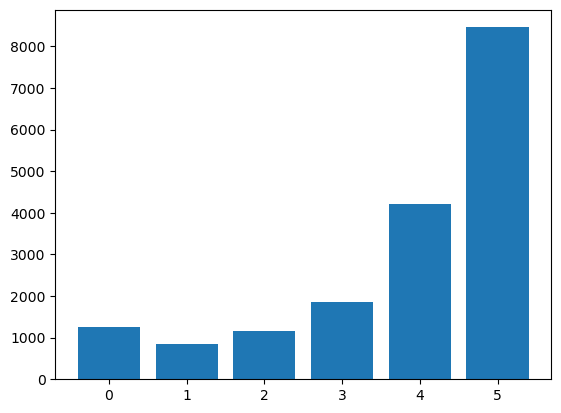

In [12]:
plt.bar((content['decade'].value_counts(sort=True).index), (content['decade'].value_counts(sort=True).values))

# content feature selection

to minimize bias, i'm only going to add the decade column to the data i will use for modeling.

In [13]:
decade = content[['id', 'decade']]
decade = decade.rename(columns = {'id': 'mid', 'decade': 'm_decade'})
decade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   mid       17770 non-null  int64
 1   m_decade  17770 non-null  int64
dtypes: int64(2)
memory usage: 277.8 KB


# ratings

importing partial datasets as csvs for ease of use

In [ ]:
#import raw data in chunks, precleaning process in data folder
d1 = pd.read_csv('data/d1_clean.csv')
d1 = d1.drop(['Unnamed: 0'], axis=1)

d2 = pd.read_csv('data/d2_clean.csv')
d2 = d2.drop(['Unnamed: 0'], axis=1)

d3 = pd.read_csv('data/d3_clean.csv')
d3 = d3.drop(['Unnamed: 0'], axis = 1)

d4 = pd.read_csv('data/d4_clean.csv')
d4 = d4.drop(['Unnamed: 0'], axis =1)

df = pd.concat([d1, d2, d3, d4], axis =0, ignore_index=True)

#sample
df = df.sample(n=1000000, random_state=1)

#dropping day and month because I changed my mind
df = df.drop(['day', 'month', 'fisc_Q', 'year'], axis=1)

#rename for clarity
df = df.rename(columns = {'date': 'r_date'})

df['r_date'] = df['r_date'].astype('datetime64[ns]')

data = df.merge(decade)

#data.to_csv('data/1mdf.csv', index=False)

# Ready for EDA

In [14]:
data = pd.read_csv('data/1mdf.csv')
data.head()

,mid,cust_id,rating,r_date,m_decade
0,3113,510180,3.0,1999-12-12,4
1,3113,1589382,4.0,2000-03-11,4
2,3113,1878798,2.0,2000-08-08,4
3,3113,1259176,4.0,2000-11-10,4
4,3113,873369,3.0,2000-11-20,4


## Exploring content attributes

- highest rated content (content quality)
- most rated content (popularity)
- decade frequency distribution

### Decade Frequency Distribution

<BarContainer object of 6 artists>

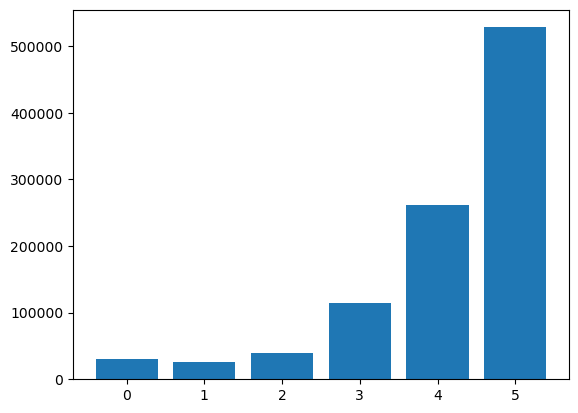

In [15]:
plt.bar((data['m_decade'].value_counts(sort=True).index), (data['m_decade'].value_counts(sort=True).values))

In [16]:
data['m_decade'].value_counts(normalize=True)

m_decade
5    0.528246
4    0.261975
3    0.113831
2    0.039405
0    0.030192
1    0.026351
Name: proportion, dtype: float64

### Looking at rating as a popularity metric - speaks to the perceived quality of the content

In [17]:
#average rating for each content piece
avgrating = data.groupby('mid')['rating'].mean().sort_values(ascending=False).to_frame()
avgrating = avgrating.rename(columns = {'rating': 'm_avg_rating'}).reset_index()
avgrating

,mid,m_avg_rating
0,12972,5.0
1,9158,5.0
2,9162,5.0
3,9173,5.0
4,2648,5.0
...,...,...
16216,17284,1.0
16217,16549,1.0
16218,6496,1.0
16219,16073,1.0


**1. What is the distribution of content ratings?**

In [18]:
avgrating['m_avg_rating'].describe()

count    16221.000000
mean         3.263065
std          0.787667
min          1.000000
25%          2.947368
50%          3.333333
75%          3.800000
max          5.000000
Name: m_avg_rating, dtype: float64

In [ ]:
#looks at distribution of avg rating per movie
avgrathist = avgrating['m_avg_rating'].plot(kind='hist');

In [ ]:
hist = plt.hist(avgrating['m_avg_rating'])

In [ ]:
ax = hist.gca() # get axis handle

Skewed to the left. Users tend to rate content above average. 

This doesn't necessarily speak to the quality of the content however it does show that our users tend to enjoy it.

In [19]:
#adding avg rating as a feature
data = data.merge(avgrating)
data.head()

,mid,cust_id,rating,r_date,m_decade,m_avg_rating
0,3113,510180,3.0,1999-12-12,4,3.187192
1,3113,1589382,4.0,2000-03-11,4,3.187192
2,3113,1878798,2.0,2000-08-08,4,3.187192
3,3113,1259176,4.0,2000-11-10,4,3.187192
4,3113,873369,3.0,2000-11-20,4,3.187192


**2. On average, do users enjoy a specific decade more than others?**

<AxesSubplot:xlabel='m_decade', ylabel='m_avg_rating'>

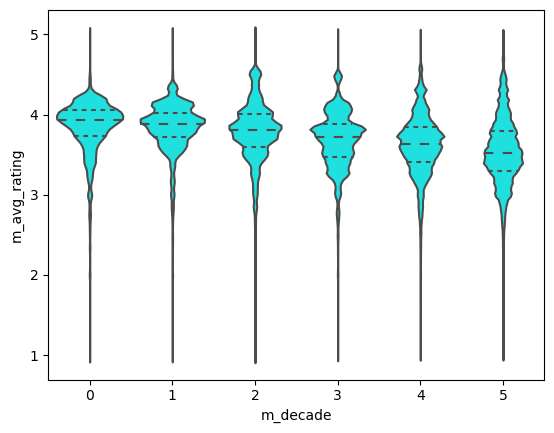

In [20]:
sns.violinplot(
    y="m_avg_rating", 
    x="m_decade", 
    data=data, 
    color='aqua',
    inner="quartile",  # Seeing the mean and quartiles
)


In [21]:
data.groupby('m_decade')['rating'].mean().sort_values(ascending=False)

m_decade
0    3.849364
1    3.836780
2    3.774851
3    3.681291
4    3.623350
5    3.542565
Name: rating, dtype: float64

On average, users may tend to rate older content slightly higher but not to a significant degree.

**3. What is the distribution of rating count? Does higher rating count indicate higher quality?**

In [22]:
popularity = data.groupby('mid')['rating'].count().sort_values(ascending=False).to_frame()
popularity = popularity.rename(columns = {'rating': 'r_count'}).reset_index()
avgrating = avgrating.merge(popularity)
avgrating.describe()

,mid,m_avg_rating,r_count
count,16221.000000,16221.000000,16221.000000
mean,8889.624499,3.263065,61.648480
std,5138.947282,0.787667,175.357348
min,1.000000,1.000000,1.000000
25%,4439.000000,2.947368,2.000000
50%,8878.000000,3.333333,7.000000
75%,13346.000000,3.800000,32.000000
max,17770.000000,5.000000,2269.000000


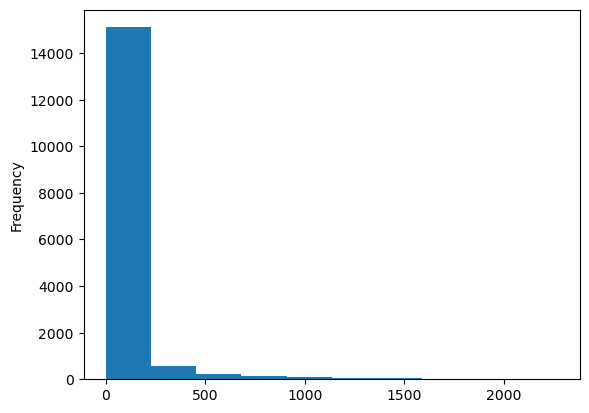

In [23]:
#looks at distribution of rating count per video
avgrating['r_count'].plot(kind='hist');

In [ ]:
sns.scatterplot(x=avgrating['r_count'],y=avgrating['m_avg_rating']);

<AxesSubplot:xlabel='r_count', ylabel='m_avg_rating'>

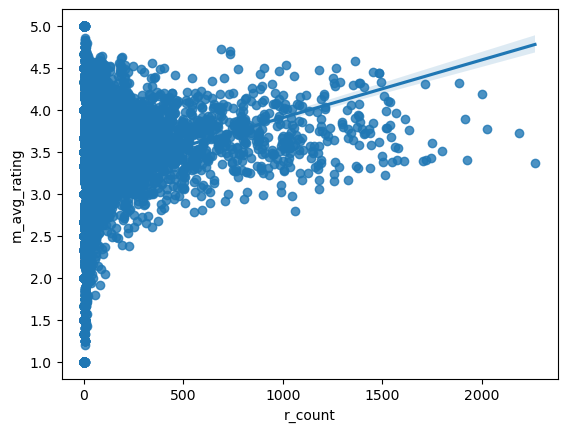

In [24]:
sns.regplot(data = avgrating, x='r_count', y='m_avg_rating')

### Thoughts on content attributes

- Popularity: content pieces on avg have 12 ratings, though it can range up to 4606 ratings. More popular content has an above average rating. I'll address popularity bias in my models

- Quality: I'm certain that quality directly impacts consumer experience so I made it a feature I'd like to keep an eye on

- Decade: grouping by decade rather than year released is more meaningful in that it also describes potential stylistic preferences or nostalgia/emotional attachments


## User behavior

**1. Most active users**

In [25]:
users = data.groupby('cust_id')['rating'].count().sort_values(ascending=False).to_frame()
users = users.rename(columns = {'rating': 'user_engagement'}).reset_index()
users.describe()

,cust_id,user_engagement
count,2.900220e+05,290022.000000
mean,1.322388e+06,3.448014
std,7.652185e+05,3.694112
min,6.000000e+00,1.000000
25%,6.594545e+05,1.000000
50%,1.319308e+06,2.000000
75%,1.984964e+06,4.000000
max,2.649429e+06,192.000000


In [26]:
users.head()

,cust_id,user_engagement
0,305344,192
1,2439493,161
2,1664010,155
3,387418,154
4,2118461,154


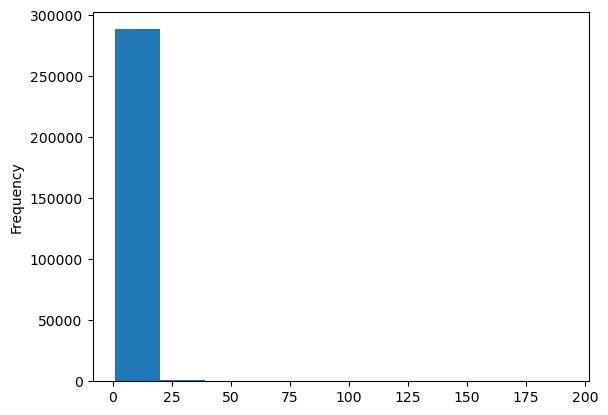

In [31]:
#looks at distribution of avg # of ratings per user
user_eng = users['user_engagement'].plot(kind='hist');

In [32]:
def activity(row):
    
    """
    bins users by activity level
    """
    if row['user_engagement'] == 1:
        return 1
    elif row['user_engagement'] == 2:
        return 2
    elif 3 <= row['user_engagement'] <= 4:
        return 3
    elif 5 <= row['user_engagement'] <= 10:
        return 4
    else:
        #these are super users
        return 5

In [33]:
users['cust_act_activity_rank'] = users.apply(activity, axis=1)
users.head()

,cust_id,user_engagement,cust_act_activity_rank
0,305344,192,5
1,2439493,161,5
2,1664010,155,5
3,387418,154,5
4,2118461,154,5


In [34]:
users['cust_act_activity_rank'].value_counts() 

cust_act_activity_rank
1    104451
3     59647
2     57388
4     54424
5     14112
Name: count, dtype: int64

<BarContainer object of 5 artists>

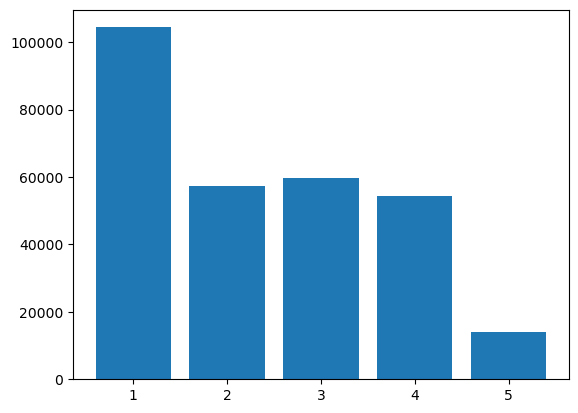

In [35]:
plt.bar((users['cust_act_activity_rank'].value_counts(sort=True).index), 
        (users['cust_act_activity_rank'].value_counts(sort=True).values))

In [38]:
usereng = users['cust_act_activity_rank'].value_counts().to_frame()
usereng

,count
cust_act_activity_rank,
1,104451
3,59647
2,57388
4,54424
5,14112


In [39]:
usereng.to_csv('data/usereng.csv')

**Early Adopters Curve**

2.5% innovators
13.5% early adopters
34% early majority
34% late majority
16% laggards

In [ ]:
first_reviews = data.drop_duplicates(subset='cust_id', keep='first')
#sort vals by date, prep to split linearly
first_reviews['r_date'] = first_reviews['r_date'].astype('datetime64[ns]')
first_reviews = first_reviews.sort_values(by=['r_date'])
first_reviews

In [ ]:
def adopters(df):
    row_count = len(df)
    inn = round(row_count * 0.025)
    earlya = round(row_count * 0.135)
    earlym = round(row_count * 0.34)
    latem = round(row_count * 0.34)
    lag = row_count - (inn + earlya + earlym + latem)
    
    df['adopters'] = 0
    
    start_index = 0
    end_index = inn
    df.iloc[start_index:end_index, -1] = 1

    start_index = end_index
    end_index += earlya
    df.iloc[start_index:end_index, -1] = 2

    start_index = end_index
    end_index += earlym
    df.iloc[start_index:end_index, -1] = 3

    start_index = end_index
    end_index += latem
    df.iloc[start_index:end_index, -1] = 4

    start_index = end_index
    end_index += lag
    df.iloc[start_index:end_index, -1] = 5

    return df

In [ ]:
adopters(first_reviews)
first_reviews.head()

In [ ]:
first_reviews = first_reviews[['cust_id', 'adopters']]


In [ ]:
first_reviews

In [ ]:
data = data.merge(users)
data

In [ ]:
data = data.merge(first_reviews)
data

In [ ]:
#data.to_csv('data/1m_useratt.csv', index=False)

# Diversity Requirement

In addition to the general concept of content diversity, I'd also like to examine different diversity parameters such as racial, ethnic, gender, sexual-orientation, etc. 

Because of the limited amount of time, each video was assigned True or False based on if any of the Top (2) Billed Cast, Director, or Writer(s) are a minority. White women count as minorities in this instance as they are also underrepresented in the above categories.

This part of the project was added later in the process so it was not taken into account throughout the modeling process. This was done by hand using information from IMDb and will be revisited in the future to ensure accuracy.

Based on the information that I did find, you'll see below that out of almost 18,000 videos, only about 2214 met the minority requirement. This is less than 13%.

In [49]:
diversity = pd.read_csv('data/movie_titles4.csv')
diversity = diversity.rename(columns = {'minority requirement': 'm_minreq'})
diversity = diversity.fillna(0)
diversity

,mid,yr,title,m_minreq
0,1,2003.0,Dinosaur Planet,0.0
1,2,2004.0,Isle of Man TT 2004 Review,0.0
2,3,1997.0,Character,0.0
3,4,1994.0,Paula Abdul's Get Up & Dance,1.0
4,5,2004.0,The Rise and Fall of ECW,0.0
...,...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...,1.0
17766,17767,2004.0,Fidel Castro: American Experience,0.0
17767,17768,2000.0,Epoch,0.0
17768,17769,2003.0,The Company,0.0


In [50]:
diversity['m_minreq'].value_counts()

m_minreq
0.0    15556
1.0     2214
Name: count, dtype: int64

In [51]:
diversity['m_minreq'].value_counts(normalize=True)

m_minreq
0.0    0.875408
1.0    0.124592
Name: proportion, dtype: float64

# Up Next:


